<a href="https://colab.research.google.com/github/6X10/advanced-statistical-data-analysis/blob/main/tSNE_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import seaborn as sns

In [ ]:
# MNIST, CIFAR10, CIFAR100
trainset = torchvision.datasets.MNIST(root='./datasets/', train=True,
                                        download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./datasets/', train=False,
                                       download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=100,shuffle=True) #when debugging
#trainloader = torch.utils.data.DataLoader(trainset,batch_size=1000,shuffle=True) # try later
testloader = torch.utils.data.DataLoader(testset,batch_size=1000,shuffle=True)

In [ ]:
dataiter = iter(trainloader)
tr_images, tr_labels = dataiter.next()
tr_images, tr_labels = tr_images.numpy(), tr_labels.numpy()
tr_images, tr_labels = tr_images.reshape(len(tr_images),-1), tr_labels.reshape(len(tr_labels),-1)

In [ ]:
dataiter = iter(testloader)
te_images, te_labels = dataiter.next()
te_images, te_labels = te_images.numpy(), te_labels.numpy()
te_images, te_labels = te_images.reshape(len(te_images),-1), te_labels.reshape(len(te_labels),-1)

In [ ]:
class PCA():
    def __init__(self, num_components):
        print("PCA initialized..")
        self.num_components=num_components

    #training data 기반
    def fit(self, X):
      self.X_mean = np.mean(X, axis=0)
      X_center=X-self.X_mean

      covariance=np.cov(X_center,rowvar=False) #X.shape = (num.data, num_feature)

      self.eigenvalues, self.eigenvectors = np.linalg.eig(covariance)

      sorted_index = np.argsort(self.eigenvalues)[::-1]
      sorted_eigenvalues = self.eigenvalues[sorted_index]
      sorted_eigenvectors = self.eigenvectors[:,sorted_index]

      self.top_eigenvector = sorted_eigenvectors[:, 0:self.num_components]

      X_reduced = np.dot(self.top_eigenvector.transpose(), X_center.transpose()).transpose() #linear transformation. 순서 바꾸면 transpose() 없어도 될듯?

      return X_reduced

    #training data 기반 test data 차원 축소
    def fit_transform(self, X):
      X_center = X-self.X_mean #centering by training data 기반 mean(우리의 데이터 분포는 이러한 통계적 분포를 가지고 있고, test data로 그러할 것)

      X_reduced = np.dot(self.top_eigenvector.transpose(), X_center.transpose()).transpose()

      return X_reduced

    #데이터 유사하게 복원
    def reconstruct(self, X_reduced):
        X_reconstruction = np.matmul(X_reduced, self.top_eigenvector.transpose())+self.X_mean #편향성까지 더해줌

        return X_reconstruction

In [ ]:
class tSNE:
    def __init__(self, perp, lr, num_dim=2, num_epoch=500):
        print("tSNE initialized..")

        self.num_dim = num_dim
        self.num_epoch = num_epoch
        self.perp = perp
        self.lr = lr

    #p 한번만 계산해도 됨
    def compute_p_single(self, X, i, j):
        xi,xj = X[i], X[j]
        numerator = np.exp(-np.linalg.norm(xi-xj)**2)/(2*self.perp**2)
        #denominator lator
        return numerator

    def compute_p(self, X): #original data space에서 특정 두 데이터 간 친밀도 구함
        P = np.zeros((X.shape[0], X.shape[0])) # diagonal 0
        for i in range(X.shape[0]):
          for j in range(X.shape[0]):
            if i>j: #왜냐면 Pij, pji는 같으므로
              p=self.compute_p_single(X,i,j)
              P[i,j], P[j,i] = p,p
        #분모  by lecture note 6 : 자기 자신이 아닌 다른 데이터에 대해서 summation을 해버려라
        #if keepdims=F, np.sum[M_n*n] -> M_n, if not, no.sum[M-n*n]->M_n*1 (for shape vector -> matrix)
        p1 = np.sum(P,axis=1, keepdims=True) #pj|i의 분모 : i번째 row에 대해서 쭉 더해버려라
        p2 = np.sum(P,axis=0, keepdims=True).T #pi|j의 분모 : i번째 row에 대해서 쭉 더해버려라
        return (np.divide(P, p1)+np.divide(P,p2))/(2*X.shape[0])

    #매 iteration마다 계산할 것
    def compute_q_single(self, y, i, j):
        yi, yj = y[i], y[j]
        numerator = (1+np.linalg.norm(yi-yj)**2)**(-1)
        return numerator

    def compute_q(self, y):
        Q = np.zeros((y.shape[0], y.shape[0]))
        for i in range(y.shape[0]):
          for j in range(y.shape[0]):
            if i>j:
              q=self.compute_q_single(y,i,j)
              Q[i,j], Q[j,i] = q,q #numerator
        Q_unnorm = Q
        Q /= np.sum(Q) #diagonal 0이므로
        return Q, Q_unnorm

    def fit(self, X):
        P=self.compute_p(X)
        #initialize low-dimensional embedding y by PCA (or standard gaussian~...)
        pca = PCA(num_components=2)
        y=pca.fit(X) #여기까지 아까 했고

        P[range(X.shape[0]), range(X.shape[0])] = 1. #diagonal 의미없는 1로. by 8pg, loss 구할 때 KL divergence 구해야하는데, j!=i summation 귀찮으므로.

        for iteration in range(self.num_epoch): #그때그때 y값 바뀔 때마다 q 계산해줘야 함
          Q, Q_unnorm = self.compute_q(y)
          Q[range(X.shape[0]), range(X.shape[0])]=1. #diagonal entry 0->1
          loss = np.sum(np.multiply(P, np.log(P+1e-10) - np.log(Q+1e-10))) #log 값에 0 들어가면 안되므로
          grad = np.zeros(y.shape)
          for i in range(y.shape[0]):
            grad[i] = np.sum(np.tile((P[:,i] - Q[:,i])*Q_unnorm[:,i],(self.num_dim, 1)).T*(y[i,:]-y),0) #답은 vandermaaten08a.pdf 23p Appendix A. 를 통해서 확인하면 됨.
          y -= grad*self.lr
          if iteration % 10 == 0:
            print("Epoch %d: Loss = %.2f"%(iteration, loss))
            print(y[0])
        return y


In [ ]:
model = tSNE(perp=1e+1,lr=1e+4)
#model = tSNE(perp=5e+0,lr=1e+6) # try later

tSNE initialized..


In [ ]:
tr_images_reduced = model.fit(tr_images)
tr = np.hstack([tr_images_reduced,tr_labels])

PCA initialized..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: ComplexWarning: Casting complex values to real discards the imaginary part


Epoch 0: Loss = 3.37
[-4.89563535+0.j -3.29819237+0.j]
Epoch 10: Loss = 3.12
[-5.03862223+0.j -2.73167   +0.j]
Epoch 20: Loss = 2.98
[-5.00342583+0.j -2.43179064+0.j]
Epoch 30: Loss = 2.89
[-4.96562778+0.j -2.23949775+0.j]
Epoch 40: Loss = 2.82
[-4.9622826 +0.j -2.10212774+0.j]
Epoch 50: Loss = 2.77
[-4.98207199+0.j -2.01278752+0.j]
Epoch 60: Loss = 2.73
[-5.01640621+0.j -1.96766833+0.j]
Epoch 70: Loss = 2.69
[-5.06049947+0.j -1.95673082+0.j]
Epoch 80: Loss = 2.65
[-5.11173514+0.j -1.96902577+0.j]
Epoch 90: Loss = 2.62
[-5.16908045+0.j -1.99662656+0.j]
Epoch 100: Loss = 2.59
[-5.23252113+0.j -2.03462009+0.j]
Epoch 110: Loss = 2.56
[-5.30261924+0.j -2.080016  +0.j]
Epoch 120: Loss = 2.54
[-5.38022781+0.j -2.13082185+0.j]
Epoch 130: Loss = 2.52
[-5.46628958+0.j -2.18547804+0.j]
Epoch 140: Loss = 2.49
[-5.56174058+0.j -2.24261096+0.j]
Epoch 150: Loss = 2.47
[-5.66753621+0.j -2.30101014+0.j]
Epoch 160: Loss = 2.45
[-5.7846854 +0.j -2.35964785+0.j]
Epoch 170: Loss = 2.43
[-5.91419644+0.j -2

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:4211: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


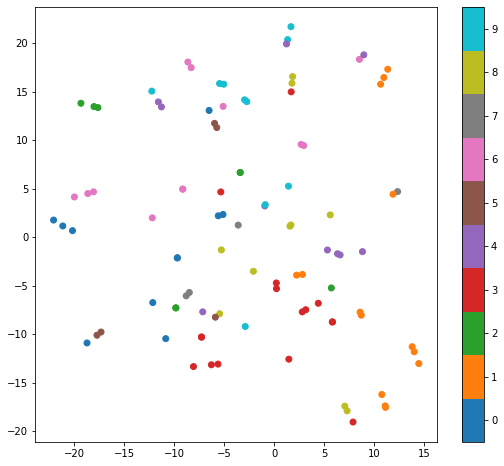

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

colors = ListedColormap(sns.color_palette())

plt.figure(figsize=(9,8))

plt.scatter(tr[:,0],tr[:,1],c=tr[:,2],cmap=colors)
plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9])
plt.clim(-.5,9.5)

plt.show()
plt.close()

여러가지 technique 빠져서 결과가 잘 나오지는 않음. sckit learn t-SNE에서 다양한 hyper parameter (perplexity, learning rate에 민감) 다양하게 있음. (method : 빨리하게 만들어줌) -> 수업 시간에 배운 건 알고리즘 적. 효율적으로 하려면 여러가지 장치 필요.